# Regression Analysis on PVI and 2022 Midterm Election Voting Behavior
This notebook offers a walkthrough of regression analysis applied to the partisan lean (PVI scores) and 2022 midterm election outcomes across US Congressional Districts. The dataset previously compiled in the data wrangling notebook 01_Data_Wrangling_ACS_Surveys features the 435 congressional districts and 451 non-duplicated features of the district. 

## Process Overview:

1. **PVI Modeling**: The process begins with a step by step walkthrough of choosing appropriate models to address our particular high dimensional high multicolinear dataset. From choosing a baseline model, to tuning a more sophisticated model, to creating pipelines to tune several models at once. 
2. **Extracting and Visualizing PVI Features and Weights**: Once the best model for predicting PVI is identified, the top features and weights that affect Democratic and Republican voter behavior will be extracted and analyzed. 
3. **2022 Midterm Voter Behavior Modeling:**  A new target is chosen corresponding to margins of victory for congressional elections in 2022. Some districts for uncontested races and same party general matchups will be eliminated from observations, then we incorporate a comprehensive pipeline gridsearch cross validation using all the same models from the previous PVI Modeling section.
4. **Extracting and Visualizing 2022 Voter Behavior Features and Weights**: Once the best model for predicting 2022 midterm behavior is identified, the top features and weights that affect Democratic and Republican voter behavior will be extracted and analyzed and ready for comparison.


# 1. PVI Modeling

## 1.a - Setting Up the Environment and Loading Data

This analysis will draw from the two distinct datasets generated in the previous data wrangling notebook (notebook 01_Data_Wrangling_ACS_Surveys): one detailing percent compositions of district characteristics (PCT) and the other containing raw totals for each district (PRF).

This analysis will concentrate on the PCT dataset, representing percentages of total populations and households because all U.S. Congressional Districts are designed to have roughly the same population (about 761,169 following the 2020 Census.) Also, election outcomes depend on the proportions of votes candidates receive.

In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('once')


In [20]:
# Load datasets
pct_df = pd.read_csv('data/Full_Dataset_PCT.csv')  
prf_df = pd.read_csv('data/Full_Dataset_PRF.csv')  

# Define target variable
y = pct_df['PVI_2023']

# Define feature variables
X = pct_df.iloc[:, 3:454]  # first two columns are titles of districts, last columns are potential targets

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 1.b - Baseline Model (Linear Regression)

Linear Regression is used for its simplicity to set a benchmark for evaluating more complex models, but it generally would not perform well on datasets with such high dimensionality and multicollinearity. 



In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

# Instantiate and fit the baseline Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions on training and test data
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Results
print("\nBaseline Linear Regression metrics:")
print(f"R-squared (Train): {r2_train:.3f}")
print(f"R-squared (Test): {r2_test:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Absolute Percentage Error: {mape:.3f}%")



Baseline Linear Regression metrics:
R-squared (Train): 1.000
R-squared (Test): -0.220
Mean Squared Error: 264.785
Root Mean Squared Error: 16.272
Mean Absolute Error: 11.059
Mean Absolute Percentage Error: 372.332%


## 1.c - Ridge Regression Model

Moving beyond the baseline, we will try Ridge Regression to address our dataset's high dimensionality and multicollinearity. This model uses L2 regularization, adding a penalty on the size of coefficients (influence) of each independent variable on the PVI target. 

The alpha parameter controls the regularization strength, with higher values applying more significant penalties to the coefficients, thus enforcing them to shrink towards zero. 

In [22]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

# Instantiate and fit the Ridge Regression model
# Note: Alpha is the regularization strength; larger values specify stronger regularization
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predictions on training and test data
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)

# Metrics
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
rmse_ridge = sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
mape_ridge = np.mean(np.abs((y_test - y_test_pred_ridge) / y_test)) * 100

# Results
print("\nRidge Regression metrics:")
print(f"R-squared (Train): {r2_train_ridge:.3f}")
print(f"R-squared (Test): {r2_test_ridge:.3f}")
print(f"Mean Squared Error: {mse_ridge:.3f}")
print(f"Root Mean Squared Error: {rmse_ridge:.3f}")
print(f"Mean Absolute Error: {mae_ridge:.3f}")
print(f"Mean Absolute Percentage Error: {mape_ridge:.3f}%")



Ridge Regression metrics:
R-squared (Train): 0.999
R-squared (Test): 0.646
Mean Squared Error: 76.931
Root Mean Squared Error: 8.771
Mean Absolute Error: 6.906
Mean Absolute Percentage Error: 193.838%


#### Ridge Regression significantly improves upon the baseline, particularly in test set performance. However, the large gap between training (R²: 0.999) and test (R²: 0.646) R-squared values shows strong overfitting.



## 1.d Tuning Alpha in Ridge Regression

Experimenting with different alpha values to address the overfitting problem


In [23]:
from sklearn.linear_model import RidgeCV

# Define a range of alpha values to test
alpha_values = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# Setup RidgeCV with specified alphas and cross-validation
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)

# Fit the model to the training data
ridge_cv.fit(X_train, y_train)

# Best alpha value
print(f"Optimal alpha: {ridge_cv.alpha_}")

# Predictions on training and test data using the best alpha
y_train_pred_ridge_cv = ridge_cv.predict(X_train)
y_test_pred_ridge_cv = ridge_cv.predict(X_test)

# Metrics using the best alpha
r2_train_ridge_cv = r2_score(y_train, y_train_pred_ridge_cv)
r2_test_ridge_cv = r2_score(y_test, y_test_pred_ridge_cv)
mse_ridge_cv = mean_squared_error(y_test, y_test_pred_ridge_cv)
rmse_ridge_cv = sqrt(mse_ridge_cv)
mae_ridge_cv = mean_absolute_error(y_test, y_test_pred_ridge_cv)
mape_ridge_cv = np.mean(np.abs((y_test - y_test_pred_ridge_cv) / y_test)) * 100

# Results
print("\nOptimized Ridge Regression metrics:")
print(f"R-squared (Train): {r2_train_ridge_cv:.3f}")
print(f"R-squared (Test): {r2_test_ridge_cv:.3f}")
print(f"Mean Squared Error: {mse_ridge_cv:.3f}")
print(f"Root Mean Squared Error: {rmse_ridge_cv:.3f}")
print(f"Mean Absolute Error: {mae_ridge_cv:.3f}")
print(f"Mean Absolute Percentage Error: {mape_ridge_cv:.3f}%")


Optimal alpha: 1000.0

Optimized Ridge Regression metrics:
R-squared (Train): 0.974
R-squared (Test): 0.900
Mean Squared Error: 21.796
Root Mean Squared Error: 4.669
Mean Absolute Error: 3.692
Mean Absolute Percentage Error: 135.961%


#### Alpha-tuning in Ridge Regression to 1000.0 markedly improved test R-squared from 0.646 to 0.900 and reduced overfitting, as seen in the narrowed gap between train and test R-squared values (from 0.999 to 0.974 for train, and 0.646 to 0.900 for test). 

#### Continued in the next cell, we try to find a more optimal alpha value.


In [34]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from math import sqrt

# New range of alpha values to test
alpha_values = [10, 100, 250, 750, 1000, 2000]

# Setup RidgeCV with specified alphas, enabling storage of CV values
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)

# Fit the model to the training data
ridge_cv.fit(X_train, y_train)

# Best alpha value
print(f"Optimal alpha: {ridge_cv.alpha_}")

# Cross-validated R² and Negative Mean Squared Error
cv_r2_scores = cross_val_score(ridge_cv, X_train, y_train, cv=5, scoring='r2')
cv_nmse_scores = cross_val_score(ridge_cv, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print(f"Cross-validated R²: {cv_r2_scores.mean():.3f}")
print(f"Cross-validated Negative Mean Squared Error: {cv_nmse_scores.mean():.3f}")

# Predictions on training and test data using the best alpha
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

# Metrics using the best alpha
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Results
print("\nOptimized Ridge Regression metrics:")
print(f"R-squared (Train): {r2_train:.3f}")
print(f"R-squared (Test): {r2_test:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Absolute Percentage Error: {mape:.3f}%")


Optimal alpha: 750
Cross-validated R²: 0.896
Cross-validated Negative Mean Squared Error: -28.591

Optimized Ridge Regression metrics:
R-squared (Train): 0.976
R-squared (Test): 0.900
Mean Squared Error: 21.804
Root Mean Squared Error: 4.669
Mean Absolute Error: 3.722
Mean Absolute Percentage Error: 135.119%


## 1.e Preprocessing Pipeline with Ridge Regression

This step evaluates the influence of preprocessing techniques on Ridge Regression. We integrate StandardScaler, MinMaxScaler, and RobustScaler within a pipeline to improve regression outcomes.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

# Define a function to display metrics
def display_metrics(y_train, y_train_pred, y_test, y_test_pred, preprocessor_name):
    # Training metrics
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)

    # Test metrics
    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    print(f"\nMetrics for {preprocessor_name}:")
    print(f"R-squared (Train): {r2_train:.3f}, R-squared (Test): {r2_test:.3f}")
    print(f"Mean Squared Error (Test): {mse_test:.3f}, Root Mean Squared Error (Test): {rmse_test:.3f}")
    print(f"Mean Absolute Error (Test): {mae_test:.3f}, Mean Absolute Percentage Error (Test): {mape_test:.3f}%")

# Define the preprocessors/scalers you want to test
preprocessors = {
    'Standard Scaler': StandardScaler(),
    'Min Max Scaler': MinMaxScaler(),
    'Robust Scaler': RobustScaler(),
    'No Scaler': None  # To compare performance without any scaling
}

# Define the range of alpha values for RidgeCV
alpha_values = [0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 
                100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]

# Iterate over each preprocessor
for preprocessor_name, preprocessor in preprocessors.items():
    steps = [('ridgecv', RidgeCV(alphas=alpha_values, store_cv_values=True, scoring='r2'))]
    if preprocessor is not None:
        steps.insert(0, ('preprocessor', preprocessor))  # Add preprocessor as the first step
    pipeline = Pipeline(steps=steps)

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Extract the RidgeCV step after fitting
    fitted_ridge_cv = pipeline.named_steps['ridgecv']

    # Optimal alpha value from RidgeCV within the pipeline
    print(f"\nUsing {preprocessor_name}, Optimal alpha: {fitted_ridge_cv.alpha_}")

    # Predictions on training and test data using the pipeline
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Compute and display metrics
    display_metrics(y_train, y_train_pred, y_test, y_test_pred, preprocessor_name)



Using Standard Scaler, Optimal alpha: 50.0

Metrics for Standard Scaler:
R-squared (Train): 0.976, R-squared (Test): 0.913
Mean Squared Error (Test): 18.894, Root Mean Squared Error (Test): 4.347
Mean Absolute Error (Test): 3.339, Mean Absolute Percentage Error (Test): 147.830%

Using Min Max Scaler, Optimal alpha: 1.0

Metrics for Min Max Scaler:
R-squared (Train): 0.979, R-squared (Test): 0.912
Mean Squared Error (Test): 19.057, Root Mean Squared Error (Test): 4.365
Mean Absolute Error (Test): 3.266, Mean Absolute Percentage Error (Test): 166.148%

Using Robust Scaler, Optimal alpha: 50.0

Metrics for Robust Scaler:
R-squared (Train): 0.974, R-squared (Test): 0.907
Mean Squared Error (Test): 20.262, Root Mean Squared Error (Test): 4.501
Mean Absolute Error (Test): 3.520, Mean Absolute Percentage Error (Test): 143.976%

Using No Scaler, Optimal alpha: 750.0

Metrics for No Scaler:
R-squared (Train): 0.976, R-squared (Test): 0.900
Mean Squared Error (Test): 21.804, Root Mean Squared E

#### Using different scalers, the Standard Scaler with alpha 50 led to the best test R-squared (0.913). It was closely followed by the Min Max Scaler (R2 0.912), but the MAPE performed much better with the Standard Scaler

## 1.f Pipeline of Multiple Models with L1 and L2 Regularization

Here I incorporated into a single pipeline LassoCV, RidgeCV, and ElasticNet model. 

The `display_features` function was defined to record and identify optimal parameters. 
Parameters were adjusted and executed iteratively within the same cell to keep the notebook focused, but all variations and results are recorded in `results_df` DataFrame after each iteration. 


In [74]:
import pandas as pd

# Initialize an empty list to collect results
results = []

def display_metrics(regressor_name, scaler_name, best_params, mean_cv_score, r2_test, gap, rmse, r2_train, mse_test, mae_test, mape_test):
    print(f"{regressor_name} with {scaler_name} metrics:")
    print(f"Best parameters: {best_params}")
    print(f"Mean CV Score (R²): {mean_cv_score:.3f}, R² Test Score: {r2_test:.3f}")
    print(f"Gap: {gap:.3f}")
    print(f"Root Mean Squared Error: {rmse:.3f}")
    print("Other Metrics:")
    print(f"R-squared (Train): {r2_train:.3f}, Mean Squared Error (Test): {mse_test:.3f}")
    print(f"Mean Absolute Error (Test): {mae_test:.3f}, Mean Absolute Percentage Error (Test): {mape_test:.3f}%")
    print()

    # Collecting results
    results.append({
        'Model': f'{regressor_name} with {scaler_name}',
        'Best Parameters': best_params,
        'Mean CV Score (R²)': mean_cv_score,
        'R² Test Score': r2_test,
        'Gap': gap,
        'RMSE': rmse,
        'R-squared (Train)': r2_train,
        'MSE (Test)': mse_test,
        'MAE (Test)': mae_test,
        'MAPE (Test)': mape_test
    })

# Example usage
# display_metrics('LassoCV', 'Standard Scaler', {'classifier__n_estimators': 200, 'classifier__max_depth': 10}, 0.874, 0.848, 0.026, 6.966, 0.898, 33.025, 4.653, 197.413)

# Convert the results list to a DataFrame for tabular display
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

Empty DataFrame
Columns: []
Index: []


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import warnings
from sklearn.exceptions import ConvergenceWarning

# Start of the context manager to suppress warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
# Define a list of regressor configurations
regressors = [
    {
        'name': 'Lasso',
        'model': Lasso(max_iter=15000, random_state=42),
        'params': {'alpha': [0.11, 0.13, 0.14, 0.16]}
    },
    {
        'name': 'Ridge',
        'model': Ridge(random_state=42),
        'params': {'alpha': [225, 250, 275, 300]}
    },
    {
        'name': 'ElasticNet',
        'model': ElasticNet(max_iter=15000, random_state=42),
        'params': {'alpha': [0.11, 0.13, 0.14, 0.16], 'l1_ratio': [0.8, 0.85, 0.9, 0.95]}
    }
]


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), None]

# Loop over each regressor and scaler
for scaler in scalers:
    for reg in regressors:
        steps = []
        if scaler is not None:
            steps.append(('scaler', scaler))
        steps.append(('regressor', reg['model']))
        pipeline = Pipeline(steps)

        param_grid = {**reg['params']}
        param_grid = {'regressor__' + key: value for key, value in param_grid.items()}

        scaler_name = scaler.__class__.__name__ if scaler is not None else 'No Scaler'
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
        gap = abs(grid_search.best_score_ - r2_test)

        # Append the metrics to the results list
        results.append({
            'Model': f'{reg["name"]} with {scaler_name}',
            'Best Parameters': grid_search.best_params_,
            'Mean CV Score (R²)': grid_search.best_score_,
            'R² Test Score': r2_test,
            'Gap': gap,
            'RMSE': rmse,
            'R-squared (Train)': r2_train,
            'MSE (Test)': mse_test,
            'MAE (Test)': mae_test,
            'MAPE (Test)': mape_test
        })

# Convert the results list to a DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.363e+02, tolerance: 7.680e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+03, tolerance: 7.956e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.513e+02, tolerance: 7.680e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.620e+02, tolerance: 7.956e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+03, tolerance: 7.910e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.231e+02, tolerance: 7.680e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e+03, tolerance: 7.785e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+03, tolerance: 7.910e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.038e+03, tolerance: 7.680e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e+03, tolerance: 7.465e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

                             Model  \
0        Lasso with StandardScaler   
1        Ridge with StandardScaler   
2   ElasticNet with StandardScaler   
3          Lasso with MinMaxScaler   
4          Ridge with MinMaxScaler   
5     ElasticNet with MinMaxScaler   
6          Lasso with RobustScaler   
7          Ridge with RobustScaler   
8     ElasticNet with RobustScaler   
9             Lasso with No Scaler   
10            Ridge with No Scaler   
11       ElasticNet with No Scaler   
12       Lasso with StandardScaler   
13       Ridge with StandardScaler   
14  ElasticNet with StandardScaler   
15         Lasso with MinMaxScaler   
16         Ridge with MinMaxScaler   
17    ElasticNet with MinMaxScaler   
18         Lasso with RobustScaler   
19         Ridge with RobustScaler   
20    ElasticNet with RobustScaler   
21            Lasso with No Scaler   
22            Ridge with No Scaler   
23       ElasticNet with No Scaler   
24       Lasso with StandardScaler   
25       Rid

In [69]:
# Adjust the display settings for maximum column width
pd.set_option('display.max_colwidth', None)

results_df

# pd.set_option('display.max_colwidth', 50) #return to default setting

,Model,Best Parameters,Mean CV Score (R²),R² Test Score,Gap,RMSE,R-squared (Train),MSE (Test),MAE (Test),MAPE (Test)
0,Lasso with StandardScaler,{'regressor__alpha': 0.1},0.928289,0.887340,0.040949,4.945078,0.971118,24.453797,3.900211,172.905708
1,Ridge with StandardScaler,{'regressor__alpha': 100},0.908637,0.908127,0.000510,4.465625,0.966623,19.941806,3.454786,156.541543
2,ElasticNet with StandardScaler,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}",0.927870,0.891141,0.036729,4.860942,0.971632,23.628761,3.814395,170.193293
3,Lasso with MinMaxScaler,{'regressor__alpha': 0.01},0.927225,0.889590,0.037635,4.895448,0.976635,23.965409,3.789312,187.303907
4,Ridge with MinMaxScaler,{'regressor__alpha': 1},0.916570,0.912203,0.004367,4.365450,0.979120,19.057151,3.266124,166.147589
5,ElasticNet with MinMaxScaler,"{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}",0.927278,0.893891,0.033387,4.799154,0.974210,23.031881,3.691738,194.764031
6,Lasso with RobustScaler,{'regressor__alpha': 0.1},0.925521,0.880927,0.044593,5.083866,0.969375,25.845697,3.904088,170.923423
7,Ridge with RobustScaler,{'regressor__alpha': 100},0.905737,0.903269,0.002468,4.582158,0.964706,20.996171,3.584739,138.410349
8,ElasticNet with RobustScaler,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}",0.925349,0.887698,0.037651,4.937208,0.969971,24.376026,3.834577,169.483171
9,Lasso with No Scaler,{'regressor__alpha': 0.1},0.895115,0.884970,0.010145,4.996818,0.983019,24.968189,3.685412,149.060603


In [78]:
results_df.to_pickle('data/results_backup.pkl')


#### We will evaluate the above results when we complete experimenting with additional models

# 1.g Additional Models with Feature Selection

In the next section we'll explore three additional models -- RandomForestRegressor, GradientBoostingRegressor, and ExtraTreesRegressor. Each evaluates best features node splitting. Parameter tuning is iteratively conducted and appended to the `results_df` DataFrame and evaluated


In [81]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import numpy as np
import pandas as pd

# Updated list of regressor configurations
regressors = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [200, 300],  # Keeping the range around the best found
            'regressor__max_features': ['auto', 'sqrt']  # Exploring different features to consider at each split
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [300, 400],  # Increasing the number of estimators
            'regressor__learning_rate': [0.15, 0.2],  # Keeping the learning rate as is
            'regressor__max_depth': [4, 5],  # Exploring slightly deeper trees
            'regressor__subsample': [0.8, 1.0]  # Adding subsample to introduce more randomness
        }
    },
    {
        'name': 'ExtraTreesRegressor',
        'model': ExtraTreesRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [400, 500],  # Increasing the number of trees
            'regressor__max_depth': [20, 30],  # Allowing for deeper trees
            'regressor__max_features': ['auto', 'sqrt']  # Exploring different features to consider at each split
        }
    }
]

# Assuming the rest of your pipeline setup (including scalers and the GridSearchCV setup) remains the same


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), None]

for scaler in scalers:
    for reg in regressors:
        steps = []
        if scaler is not None:
            steps.append(('scaler', scaler))
        steps.append(('regressor', reg['model']))
        pipeline = Pipeline(steps)

        param_grid = {**reg['params']}

        scaler_name = scaler.__class__.__name__ if scaler is not None else 'No Scaler'
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
        gap = abs(grid_search.best_score_ - r2_test)

        display_metrics(reg['name'], scaler_name, grid_search.best_params_, grid_search.best_score_, r2_test, gap, rmse, r2_train, mse_test, mae_test, mape_test)

results_df = pd.DataFrame(results)
print(results_df)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomForestRegressor with StandardScaler metrics:
Best parameters: {'regressor__max_features': 'sqrt', 'regressor__n_estimators': 300}
Mean CV Score (R²): 0.839, R² Test Score: 0.850
Gap: 0.011
Root Mean Squared Error: 5.698
Other Metrics:
R-squared (Train): 0.980, Mean Squared Error (Test): 32.470
Mean Absolute Error (Test): 4.541, Mean Absolute Percentage Error (Test): 197.701%

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GradientBoostingRegressor with StandardScaler metrics:
Best parameters: {'regressor__learning_rate': 0.15, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Mean CV Score (R²): 0.871, R² Test Score: 0.869
Gap: 0.002
Root Mean Squared Error: 5.329
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 28.397
Mean Absolute Error (Test): 4.166, Mean Absolute Percentage Error (Test): 204.366%

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ExtraTreesRegressor with StandardScaler metrics:
Best parameters: {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400}
Mean CV Score (R²): 0.851, R² Test Score: 0.853
Gap: 0.002
Root Mean Squared Error: 5.642
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 31.836
Mean Absolute Error (Test): 4.606, Mean Absolute Percentage Error (Test): 195.422%

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomForestRegressor with MinMaxScaler metrics:
Best parameters: {'regressor__max_features': 'sqrt', 'regressor__n_estimators': 300}
Mean CV Score (R²): 0.839, R² Test Score: 0.850
Gap: 0.011
Root Mean Squared Error: 5.704
Other Metrics:
R-squared (Train): 0.980, Mean Squared Error (Test): 32.533
Mean Absolute Error (Test): 4.542, Mean Absolute Percentage Error (Test): 197.186%

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GradientBoostingRegressor with MinMaxScaler metrics:
Best parameters: {'regressor__learning_rate': 0.15, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Mean CV Score (R²): 0.869, R² Test Score: 0.872
Gap: 0.002
Root Mean Squared Error: 5.278
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 27.853
Mean Absolute Error (Test): 4.040, Mean Absolute Percentage Error (Test): 225.084%

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ExtraTreesRegressor with MinMaxScaler metrics:
Best parameters: {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400}
Mean CV Score (R²): 0.851, R² Test Score: 0.853
Gap: 0.002
Root Mean Squared Error: 5.642
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 31.836
Mean Absolute Error (Test): 4.606, Mean Absolute Percentage Error (Test): 195.422%

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomForestRegressor with RobustScaler metrics:
Best parameters: {'regressor__max_features': 'sqrt', 'regressor__n_estimators': 300}
Mean CV Score (R²): 0.839, R² Test Score: 0.850
Gap: 0.011
Root Mean Squared Error: 5.701
Other Metrics:
R-squared (Train): 0.980, Mean Squared Error (Test): 32.507
Mean Absolute Error (Test): 4.542, Mean Absolute Percentage Error (Test): 197.875%

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GradientBoostingRegressor with RobustScaler metrics:
Best parameters: {'regressor__learning_rate': 0.15, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Mean CV Score (R²): 0.876, R² Test Score: 0.871
Gap: 0.005
Root Mean Squared Error: 5.284
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 27.925
Mean Absolute Error (Test): 4.163, Mean Absolute Percentage Error (Test): 195.733%

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ExtraTreesRegressor with RobustScaler metrics:
Best parameters: {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400}
Mean CV Score (R²): 0.851, R² Test Score: 0.853
Gap: 0.002
Root Mean Squared Error: 5.642
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 31.836
Mean Absolute Error (Test): 4.606, Mean Absolute Percentage Error (Test): 195.422%

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomForestRegressor with No Scaler metrics:
Best parameters: {'regressor__max_features': 'sqrt', 'regressor__n_estimators': 300}
Mean CV Score (R²): 0.839, R² Test Score: 0.850
Gap: 0.011
Root Mean Squared Error: 5.714
Other Metrics:
R-squared (Train): 0.980, Mean Squared Error (Test): 32.654
Mean Absolute Error (Test): 4.546, Mean Absolute Percentage Error (Test): 198.144%

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GradientBoostingRegressor with No Scaler metrics:
Best parameters: {'regressor__learning_rate': 0.15, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Mean CV Score (R²): 0.870, R² Test Score: 0.866
Gap: 0.004
Root Mean Squared Error: 5.403
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 29.191
Mean Absolute Error (Test): 4.106, Mean Absolute Percentage Error (Test): 230.316%

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ExtraTreesRegressor with No Scaler metrics:
Best parameters: {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400}
Mean CV Score (R²): 0.851, R² Test Score: 0.853
Gap: 0.002
Root Mean Squared Error: 5.642
Other Metrics:
R-squared (Train): 1.000, Mean Squared Error (Test): 31.836
Mean Absolute Error (Test): 4.606, Mean Absolute Percentage Error (Test): 195.422%

                                          Model  \
0                     Lasso with StandardScaler   
1                     Ridge with StandardScaler   
2                ElasticNet with StandardScaler   
3                       Lasso with MinMaxScaler   
4                       Ridge with MinMaxScaler   
..                                          ...   
67  GradientBoostingRegressor with RobustScaler   
68        ExtraTreesRegressor with RobustScaler   
69         RandomForestRegressor with No Scaler   
70     GradientBoostingRegressor with No Scaler   
71           ExtraTreesRegressor 

In [82]:
# Adjust the display settings for maximum column width
pd.set_option('display.max_colwidth', None)

results_df

# pd.set_option('display.max_colwidth', 50) #return to default setting

,Model,Best Parameters,Mean CV Score (R²),R² Test Score,Gap,RMSE,R-squared (Train),MSE (Test),MAE (Test),MAPE (Test)
0,Lasso with StandardScaler,{'regressor__alpha': 0.1},0.928289,0.887340,0.040949,4.945078,0.971118,24.453797,3.900211,172.905708
1,Ridge with StandardScaler,{'regressor__alpha': 100},0.908637,0.908127,0.000510,4.465625,0.966623,19.941806,3.454786,156.541543
2,ElasticNet with StandardScaler,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}",0.927870,0.891141,0.036729,4.860942,0.971632,23.628761,3.814395,170.193293
3,Lasso with MinMaxScaler,{'regressor__alpha': 0.01},0.927225,0.889590,0.037635,4.895448,0.976635,23.965409,3.789312,187.303907
4,Ridge with MinMaxScaler,{'regressor__alpha': 1},0.916570,0.912203,0.004367,4.365450,0.979120,19.057151,3.266124,166.147589
...,...,...,...,...,...,...,...,...,...,...
67,GradientBoostingRegressor with RobustScaler,"{'regressor__learning_rate': 0.15, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}",0.876344,0.871346,0.004998,5.284453,1.000000,27.925447,4.163018,195.732636
68,ExtraTreesRegressor with RobustScaler,"{'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400}",0.851263,0.853329,0.002066,5.642360,1.000000,31.836224,4.605600,195.421558
69,RandomForestRegressor with No Scaler,"{'regressor__max_features': 'sqrt', 'regressor__n_estimators': 300}",0.838943,0.849563,0.010620,5.714336,0.979822,32.653631,4.545699,198.143984
70,GradientBoostingRegressor with No Scaler,"{'regressor__learning_rate': 0.15, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}",0.869567,0.865515,0.004052,5.402875,1.000000,29.191053,4.106420,230.316171


In [84]:
results_df.to_csv('data/model_metrics_pvi.csv')

# 2. Model Evaluation
In this section, I am prioritizing the 'R² Test Score' as our most important evaluation metric because it represents the proportion of variance in our target variable (PVI-score) that is predictable from the independent variables in our unseen test data. By focusing on the R² Test Score, we aim to identify models that not only fit our training data well but also generalize effectively to the new, unseen data.

In [85]:
# Sort the dataframe by 'R² Test Score' in descending order and display the top 5 models
top_5_models = results_df.sort_values(by='R² Test Score', ascending=False).head(5)
top_5_models


,Model,Best Parameters,Mean CV Score (R²),R² Test Score,Gap,RMSE,R-squared (Train),MSE (Test),MAE (Test),MAPE (Test)
4,Ridge with MinMaxScaler,{'regressor__alpha': 1},0.916570,0.912203,0.004367,4.365450,0.979120,19.057151,3.266124,166.147589
1,Ridge with StandardScaler,{'regressor__alpha': 100},0.908637,0.908127,0.000510,4.465625,0.966623,19.941806,3.454786,156.541543
13,Ridge with StandardScaler,{'regressor__alpha': 125},0.906316,0.905574,0.000741,4.527242,0.962807,20.495916,3.510842,159.716422
7,Ridge with RobustScaler,{'regressor__alpha': 100},0.905737,0.903269,0.002468,4.582158,0.964706,20.996171,3.584739,138.410349
19,Ridge with RobustScaler,{'regressor__alpha': 125},0.903327,0.901500,0.001827,4.623876,0.961007,21.380233,3.641952,136.262081


#### We can immediately see that Ridge Regression models are all top 5 best performing based on 'R² Test Score', signaling their efficacy in managing multicollinearity within the extensive demographic feature set. 

#### The leading model also has the lowest RMSE at 4.365, meaning we can make more precise PVI score predictions with an average deviation of ±4.365 points. 

#### The collective performance of these models underscores Ridge Regression's suitability for demographic-based PVI score prediction, with significant implications for targeted campaign strategies.



# 2.a Extract Top Features and Associated Weights
First I'll manually fit the best model and then extract the most Democratic features and Republican features and their associated weights

In [87]:
# Retrain the model with the best metrics on our data
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', Ridge(alpha=1))
])

# Train the model on the training data
best_model_pvi = pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model_pvi.predict(X_test)

# Calculate the R² score, RMSE, and MAE to confirm it's properly fit
r2_test = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Display the metrics
print(f"R² on Test Data: {r2_test:.4f}")
print(f"RMSE on Test Data: {rmse:.4f}")
print(f"MAE on Test Data: {mae:.4f}")


R² on Test Data: 0.9122
RMSE on Test Data: 4.3654
MAE on Test Data: 3.2661


In [89]:
# Access the coefficients of the Ridge model from the pipeline
ridge_coefficients = best_model_pvi.named_steps['regressor'].coef_

# Get the feature names from the columns of X
feature_names = X.columns

# Zip together feature names with their coefficients from the model
features_and_weights = list(zip(feature_names, ridge_coefficients))

# Sort the features by their weight
features_and_weights.sort(key=lambda x: x[1])

# Top 45 most Republican features (negative weights)
top_republican_features = features_and_weights[:45]

# Top 45 most Democratic features (positive weights)
top_democratic_features = features_and_weights[-45:]

In [90]:
top_democratic_features

[('PLACE OF BIRTH - Native - Different state', 2.206563447217098),
 ('UNITS IN STRUCTURE - 1-unit, detached', 2.2117192316221574),
 ('Total households - Cohabiting couple household', 2.2246404872248875),
 ('INCOME AND BENEFITS - Total households - With cash public assistance income - Mean cash public assistance income (dollars)',
  2.2375597474625963),
 ('HEALTH INSURANCE COVERAGE - Unemployed: - With private health insurance',
  2.3012540803424333),
 ('INCOME BELOW POVERTY LEVEL - All people - Related children of the householder 5 to 17 years',
  2.363467499040512),
 ('LANGUAGE SPOKEN AT HOME - Spanish', 2.380324396633179),
 ('Total households - Female householder, no spouse/partner present - With children of the householder under 18 years',
  2.3923215561656304),
 ('RACE - One race - Other Pacific Islander', 2.417404539419704),
 ('LANGUAGE SPOKEN AT HOME - Language other than English', 2.4789375976561194),
 ('ANCESTRY - Hungarian', 2.559714746008096),
 ('COMMUTING TO WORK - Other mea

In [133]:
import copy

top_democratic_features_pvi = copy.deepcopy(top_democratic_features)

In [91]:
top_republican_features

[('RACE - One race - White', -11.599216441586018),
 ('ANCESTRY - Italian', -7.21415827666168),
 ('INDUSTRY - Agriculture, forestry, fishing and hunting, and mining',
  -6.678904271826579),
 ('HISPANIC OR LATINO AND RACE - Cuban', -5.773822265983591),
 ('YEAR STRUCTURE BUILT - Built 1980 to 1989', -5.2902231992629165),
 ('EDUCATIONAL ATTAINMENT - Population 25 years and over - High school graduate (includes equivalency)',
  -5.286737031354059),
 ('EDUCATIONAL ATTAINMENT - Population 25 years and over - Some college, no degree',
  -5.228713371442234),
 ('HISPANIC OR LATINO AND RACE - Other Hispanic or Latino',
  -5.119856297964548),
 ('COMMUTING TO WORK - Car, truck, or van -- drove alone', -4.239667039322754),
 ('Females 15 years and over - Widowed', -4.053178739092381),
 ('INCOME BELOW POVERTY LEVEL - Married couple families', -3.794924602633972),
 ('INCOME AND BENEFITS - Total households - $100,000 to $149,999',
  -3.5516742806900368),
 ('Total households - Married-couple household', 

In [132]:
import copy

top_republican_features_pvi = copy.deepcopy(top_republican_features)

# 2.b Visualize top Democratic and Republican Features

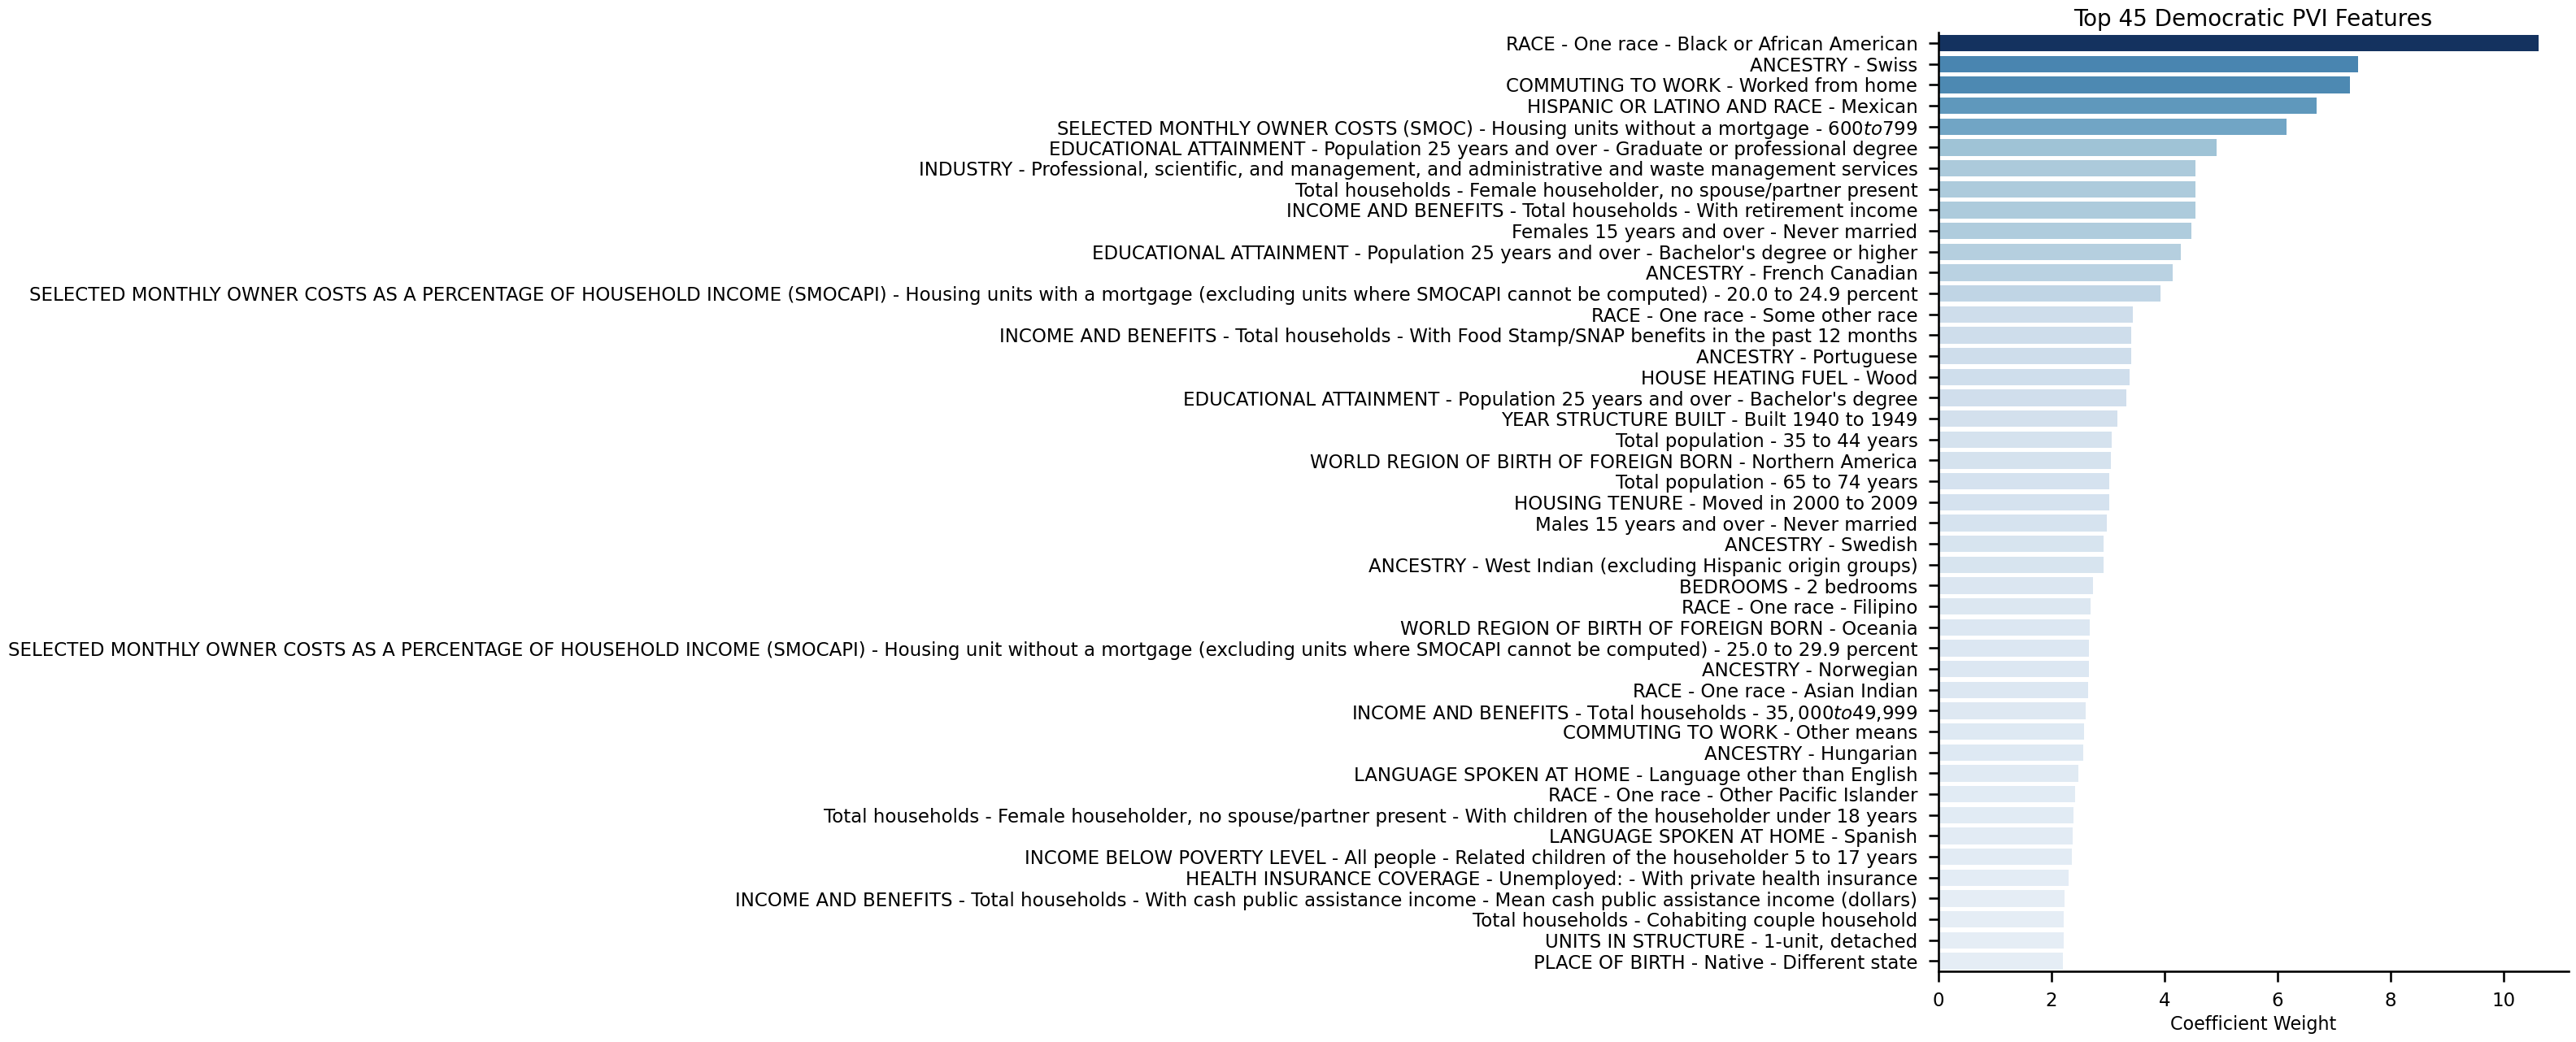

<Figure size 1040x715 with 0 Axes>

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure the strongest predictor is at the top by reversing the order
democratic_features = list(democratic_features)[::-1]
democratic_weights = list(democratic_weights)[::-1]

# Normalize the weights, but adjust the range to prevent the colors from going too light
# For example, we can set the minimum to 0.3 to avoid the lightest blues
norm = plt.Normalize(np.min(democratic_weights) * 0.55, np.max(democratic_weights))
colors = plt.cm.Blues(norm(democratic_weights))

# Create a palette that maps each weight to a color
palette = sns.color_palette(colors)

# Set the context for the plot
sns.set_context("talk")  # Adjust to "poster" for even larger elements

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 15))

# Plot the Democratic features using the adjusted palette
sns.barplot(x=democratic_weights, y=democratic_features, palette=palette, ax=ax)

# Set labels and title
ax.set_xlabel('Coefficient Weight', fontsize=16)
ax.set_title('Top 45 Democratic PVI Features', fontsize=20)

# Remove axes spines on the top and right
sns.despine()

# Show the plot
plt.show()
plt.savefig('top_democratic_features_pvi.png', bbox_inches='tight', dpi=300)


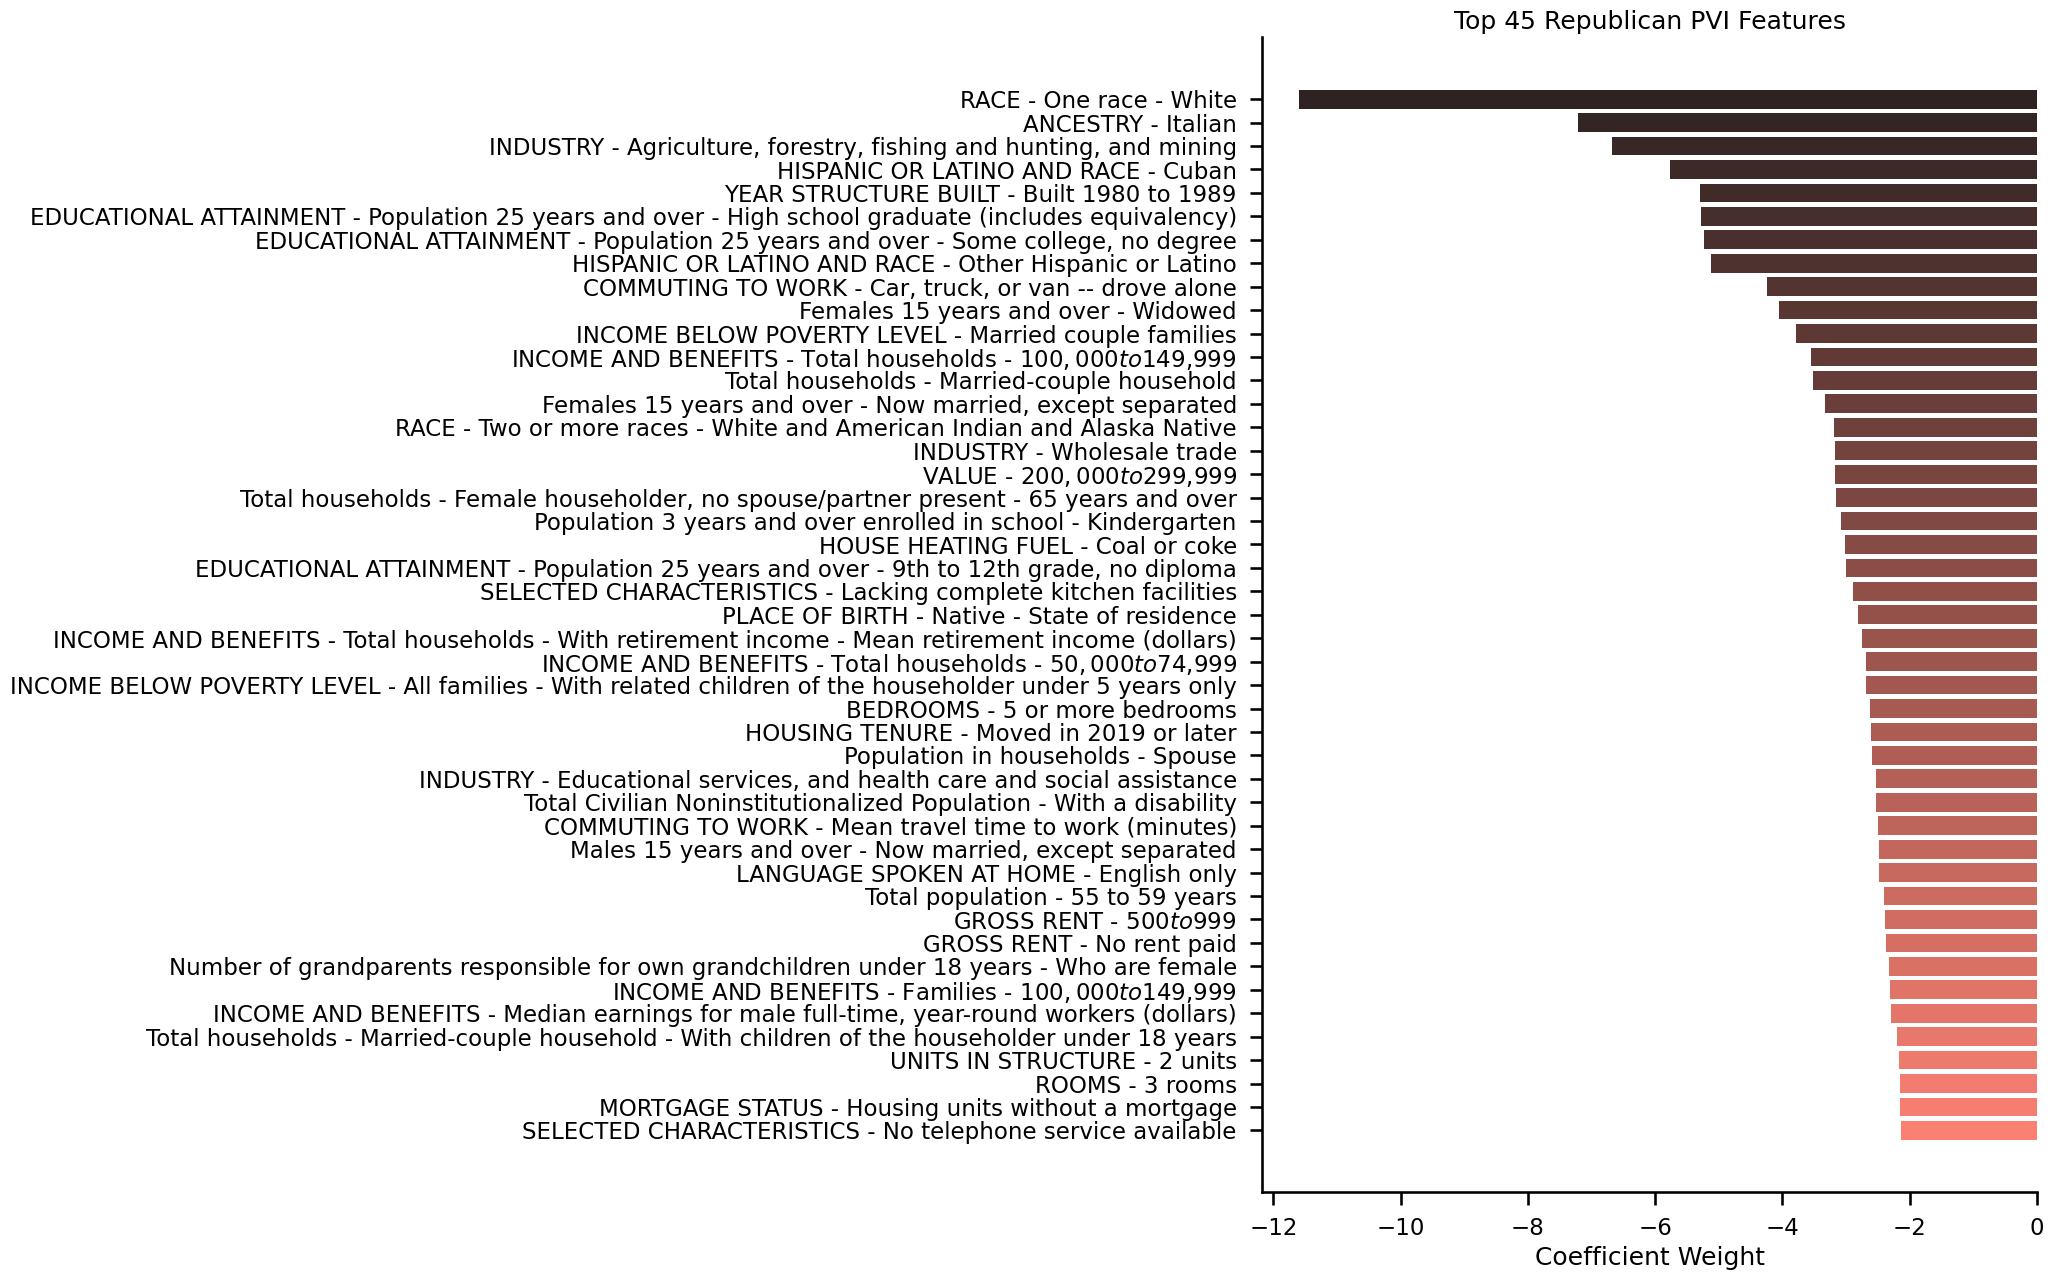

<Figure size 1040x715 with 0 Axes>

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'top_republican_features' is already defined and sorted
# Sort the features based on the absolute weights to ensure the strongest predictor is at the top
republican_features, republican_weights = zip(*sorted(top_republican_features, key=lambda x: abs(x[1]), reverse=True))

# Use a predefined Seaborn palette and reverse it for the correct gradient direction
palette = sns.color_palette("dark:salmon_r", len(republican_features))[::-1]

# Set the context for the plot
sns.set_context("talk")  # Adjust to "poster" for even larger elements

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 15))

# Plot each bar with a color from the reversed palette
for i, (feature, weight) in enumerate(zip(republican_features, republican_weights)):
    ax.barh(i, weight, color=palette[i])

# Set the y-ticks to the feature names
ax.set_yticks(np.arange(len(republican_features)))
ax.set_yticklabels(republican_features)

# Invert the y-axis to have the strongest predictors at the top
ax.invert_yaxis()

# Set labels and title
ax.set_xlabel('Coefficient Weight')
ax.set_title('Top 45 Republican PVI Features')

# Remove spines on the top and right
sns.despine()

# Show the plot
plt.show()

# Save the visualization as a PNG file
plt.savefig('top_republican_features_pvi.png', bbox_inches='tight', dpi=300)


#### blurb about alot of them not being surprising, but also about the feature weights

# 3. 2022 Midterm Modeling

This section focuses on developing a model to interpret voter behavior during the 2022 midterm elections. The analysis now concentrates on modeling the margins of victory for congressional district elections in 2022, offering a direct comparison to the Partisan Voting Index (PVI) metrics. 

Given the unique characteristics of midterm elections, such as jungle primaries and rank choice voting, these factors will be excluded to enhance model accuracy.


# 3.a Data Preparation: Filtering Outliers

By applying a filter to include only districts with a swing of less than 22 points between the 2020 and 2022 elections, outlier districts, such as those with unopposed races or Jungle Primaries (e.g., Democrat vs. Democrat races in California), were effectively excluded. The swing criterion, distinct from the margin of victory, proved effective in identifying and eliminating these atypical cases, ensuring a more standardized dataset for analysis.


In [150]:
pct_df = pd.read_csv('data/Full_Dataset_PCT.csv')
pct_df = pct_df[pct_df["Swing from 2020 presidential"].abs() <= 22] #ran unopposed
pct_df["Percent of 2020 turnout"] = pct_df["Percent of 2020 turnout"].str.rstrip('%').astype('float') #used later for streamlit

y = pct_df['2022 Margin']
X = pct_df.iloc[:,3:454]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Here I just want to check which districs got removed from observation and analysis

In [151]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
pct_df = pd.read_csv('data/Full_Dataset_PCT.csv')

# Count initial observations
initial_count = pct_df.shape[0]

# Identify districts before filtering
initial_districts = set(pct_df['Formatted_District'])  # Using 'Formatted_District' as the identifier

# Apply the filter
pct_df_filtered = pct_df[pct_df["Swing from 2020 presidential"].abs() <= 22]  # Filtering out outlier races

# Count remaining observations
remaining_count = pct_df_filtered.shape[0]

# Identify remaining districts after filtering
remaining_districts = set(pct_df_filtered['Formatted_District'])

# Identify eliminated districts
eliminated_districts = initial_districts - remaining_districts

# Sort the eliminated districts in alphabetical order
sorted_eliminated_districts = sorted(eliminated_districts)

# Print the results
print(f'Initial Observations: {initial_count}')
print(f'Remaining Observations: {remaining_count}')
print('Eliminated Districts:')
for district in sorted_eliminated_districts:
    print(district)


Initial Observations: 435
Remaining Observations: 400
Eliminated Districts:
AL-01
AL-06
AZ-08
AZ-09
CA-10
CA-15
CA-16
CA-29
CA-30
CA-34
CA-37
FL-05
FL-06
FL-18
FL-26
IL-07
LA-04
LA-06
MA-04
ND-AL
NY-09
NY-13
PA-13
PA-14
SC-03
SC-04
SD-AL
TX-06
TX-11
TX-19
TX-25
TX-26
TX-31
WI-06
WI-08


## 3.b - Baseline Model (Linear Regression)

Linear Regression is used for its simplicity to set a benchmark for evaluating more complex models, but it generally would not perform well on datasets with such high dimensionality and multicollinearity. 

In [152]:
# Instantiate and fit the baseline Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions on training and test data
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

results = []  # Initialize the results list

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Results
print("\nBaseline Linear Regression metrics:")
print(f"R-squared (Train): {r2_train:.3f}")
print(f"R-squared (Test): {r2_test:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Absolute Percentage Error: {mape:.3f}%")


Baseline Linear Regression metrics:
R-squared (Train): 1.000
R-squared (Test): -0.408
Mean Squared Error: 1352.181
Root Mean Squared Error: 36.772
Mean Absolute Error: 27.909
Mean Absolute Percentage Error: 399.652%


# 3.c - Consolidated Modeling Pipeline

The initial phase of the analysis detailed the selection and rationale behind various models. This section proceeds directly to a comprehensive pipeline, incorporating the same models from the earlier analysis for consistent comparison. Emphasis will be on tuning these pre-selected models, and the iterative process will be utilized to document various iterations in a results list.


In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Define a list of all regressor configurations
regressors = [
    {
        'name': 'Lasso',
        'model': Lasso(max_iter=15000, random_state=42),
        'params': {'regressor__alpha': [0.05, 0.1, 0.15]}  # Narrowing down the alpha range around 0.1
    },
    {
        'name': 'Ridge',
        'model': Ridge(random_state=42),
        'params': {'regressor__alpha': [50, 100, 150]}  # Adjusting the alpha range around 100
    },
    {
        'name': 'ElasticNet',
        'model': ElasticNet(max_iter=15000, random_state=42),
        'params': {
            'regressor__alpha': [0.05, 0.1, 0.15],  # Narrowing down the alpha range
            'regressor__l1_ratio': [0.8, 0.9, 1.0]  # Adjusting l1_ratio around 0.9
        }
    },  
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [150, 200, 250],  # Increasing the number of trees
            'regressor__max_depth': [None, 15, 20]  # Allowing for deeper trees
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [150, 200, 250],  # Increasing the number of trees
            'regressor__learning_rate': [0.05, 0.1, 0.15],  # Adjusting learning rate
            'regressor__max_depth': [3, 4, 5]  # Slightly increasing tree depth
        }
    },
    {
        'name': 'ExtraTreesRegressor',
        'model': ExtraTreesRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [150, 200, 250],  # Increasing the number of trees
            'regressor__max_depth': [None, 15, 20]  # Allowing for deeper trees
        }
    }
]


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), None]


# Loop over each regressor and scaler
# Loop over each regressor and scaler
for scaler in scalers:
    for reg in regressors:
        steps = []
        if scaler is not None:
            steps.append(('scaler', scaler))
        steps.append(('regressor', reg['model']))
        pipeline = Pipeline(steps)

        param_grid = reg['params']

        scaler_name = scaler.__class__.__name__ if scaler is not None else 'No Scaler'
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
        gap = abs(grid_search.best_score_ - r2_test)

        display_metrics(reg['name'], scaler_name, grid_search.best_params_, grid_search.best_score_, r2_test, gap, rmse, r2_train, mse_test, mae_test, mape_test)

results22_df = pd.DataFrame(results)
print(results22_df)
        


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Lasso with StandardScaler metrics:
Best parameters: {'regressor__alpha': 0.15}
Mean CV Score (R²): 0.857, R² Test Score: 0.868
Gap: 0.011
Root Mean Squared Error: 11.279
Other Metrics:
R-squared (Train): 0.962, Mean Squared Error (Test): 127.214
Mean Absolute Error (Test): 9.095, Mean Absolute Percentage Error (Test): 94.713%

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Ridge with StandardScaler metrics:
Best parameters: {'regressor__alpha': 150}
Mean CV Score (R²): 0.803, R² Test Score: 0.858
Gap: 0.055
Root Mean Squared Error: 11.679
Other Metrics:
R-squared (Train): 0.935, Mean Squared Error (Test): 136.407
Mean Absolute Error (Test): 8.970, Mean Absolute Percentage Error (Test): 96.600%

Fitting 5 folds for each of 9 candidates, totalling 45 fits
ElasticNet with StandardScaler metrics:
Best parameters: {'regressor__alpha': 0.15, 'regressor__l1_ratio': 0.9}
Mean CV Score (R²): 0.859, R² Test Score: 0.866
Gap

/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e+03, tolerance: 2.763e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+03, tolerance: 2.790e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

Lasso with No Scaler metrics:
Best parameters: {'regressor__alpha': 0.15}
Mean CV Score (R²): 0.806, R² Test Score: 0.824
Gap: 0.018
Root Mean Squared Error: 13.010
Other Metrics:
R-squared (Train): 0.982, Mean Squared Error (Test): 169.270
Mean Absolute Error (Test): 10.097, Mean Absolute Percentage Error (Test): 138.672%

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Ridge with No Scaler metrics:
Best parameters: {'regressor__alpha': 150}
Mean CV Score (R²): 0.832, R² Test Score: 0.828
Gap: 0.004
Root Mean Squared Error: 12.862
Other Metrics:
R-squared (Train): 0.978, Mean Squared Error (Test): 165.421
Mean Absolute Error (Test): 9.678, Mean Absolute Percentage Error (Test): 126.119%

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e+03, tolerance: 2.763e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e+03, tolerance: 2.790e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+03, tolerance: 2.654e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+03, tolerance: 2.790e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/WheeleyDope/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

ElasticNet with No Scaler metrics:
Best parameters: {'regressor__alpha': 0.15, 'regressor__l1_ratio': 0.8}
Mean CV Score (R²): 0.808, R² Test Score: 0.818
Gap: 0.010
Root Mean Squared Error: 13.206
Other Metrics:
R-squared (Train): 0.983, Mean Squared Error (Test): 174.396
Mean Absolute Error (Test): 10.200, Mean Absolute Percentage Error (Test): 141.951%

Fitting 5 folds for each of 9 candidates, totalling 45 fits
RandomForestRegressor with No Scaler metrics:
Best parameters: {'regressor__max_depth': 15, 'regressor__n_estimators': 150}
Mean CV Score (R²): 0.792, R² Test Score: 0.812
Gap: 0.020
Root Mean Squared Error: 13.447
Other Metrics:
R-squared (Train): 0.970, Mean Squared Error (Test): 180.821
Mean Absolute Error (Test): 10.072, Mean Absolute Percentage Error (Test): 129.502%

Fitting 5 folds for each of 27 candidates, totalling 135 fits
GradientBoostingRegressor with No Scaler metrics:
Best parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_

In [158]:
results22_df

,Model,Best Parameters,Mean CV Score (R²),R² Test Score,Gap,RMSE,R-squared (Train),MSE (Test),MAE (Test),MAPE (Test)
0,Lasso with StandardScaler,{'regressor__alpha': 0.1},0.853092,0.865908,0.012817,11.347605,0.971060,128.768135,9.222104,99.318556
1,Ridge with StandardScaler,{'regressor__alpha': 100},0.788260,0.862125,0.073865,11.506584,0.946238,132.401466,8.873169,91.920182
2,ElasticNet with StandardScaler,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}",0.849762,0.860131,0.010369,11.589481,0.969751,134.316076,9.346998,90.075106
3,RandomForestRegressor with StandardScaler,"{'regressor__max_depth': None, 'regressor__n_estimators': 100}",0.792181,0.804913,0.012732,13.687285,0.969809,187.341759,10.247975,129.592556
4,GradientBoostingRegressor with StandardScaler,"{'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}",0.808884,0.836446,0.027561,12.532407,0.999405,157.061223,9.448164,128.131194
5,ExtraTreesRegressor with StandardScaler,"{'regressor__max_depth': 10, 'regressor__n_estimators': 200}",0.807102,0.819392,0.012290,13.169566,0.999597,173.437476,9.773114,117.871639
6,Lasso with MinMaxScaler,{'regressor__alpha': 0.1},0.852075,0.877982,0.025908,10.824664,0.909227,117.173360,8.654225,95.933818
7,Ridge with MinMaxScaler,{'regressor__alpha': 10},0.828536,0.849152,0.020616,12.035761,0.900061,144.859553,9.118202,107.741210
8,ElasticNet with MinMaxScaler,"{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}",0.848026,0.878780,0.030753,10.789246,0.969878,116.407836,8.915005,86.693919
9,RandomForestRegressor with MinMaxScaler,"{'regressor__max_depth': None, 'regressor__n_estimators': 100}",0.791611,0.805367,0.013756,13.671360,0.969739,186.906079,10.275412,129.758398


#### Upon the 2nd iteration, model performance appears to not exceed its current r2-maximum (~.87). Further tuning won't drastically improve the model's predictability.

# 4. Model Evaluation '22 Midterms
Similar to the previous target, I am prioritizing the 'R² Test Score' as our most important evaluation metric because it represents the proportion of variance in our target variable (2022 Margin) that is predictable from the independent variables in our unseen test data. 

In [159]:
# Sort the dataframe by 'R² Test Score' in descending order and display the top 5 models
top_5_models = results22_df.sort_values(by='R² Test Score', ascending=False).head(5)
top_5_models


,Model,Best Parameters,Mean CV Score (R²),R² Test Score,Gap,RMSE,R-squared (Train),MSE (Test),MAE (Test),MAPE (Test)
8,ElasticNet with MinMaxScaler,"{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}",0.848026,0.878780,0.030753,10.789246,0.969878,116.407836,8.915005,86.693919
6,Lasso with MinMaxScaler,{'regressor__alpha': 0.1},0.852075,0.877982,0.025908,10.824664,0.909227,117.173360,8.654225,95.933818
32,ElasticNet with MinMaxScaler,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 1.0}",0.861727,0.877494,0.015767,10.846325,0.940456,117.642757,8.825326,91.371896
30,Lasso with MinMaxScaler,{'regressor__alpha': 0.05},0.861727,0.877494,0.015767,10.846325,0.940456,117.642757,8.825326,91.371896
24,Lasso with StandardScaler,{'regressor__alpha': 0.15},0.856701,0.867527,0.010826,11.278902,0.962297,127.213627,9.095110,94.713127


#### Although ElasticNet with MinMax Scaler had the highest R2 Test Score, I am choosing to use the Lasso with MinMax scaler alpha 0.1 as my best model based on the other metrics. 

#### The ElasticNet model seems to be significantly overfitting on its training data, while the Lasso model shows more consistency between Mean CV Score, R2 Test Score, and R-squared Training data.  Also, the difference in my most important metric (RMSE) is negligible

# 4.a Extract Top Features and Associated Weights
First I'll manually fit the best model and then extract the most Democratic features and Republican features and their associated weights for the 2022 midterm margins

In [162]:
# Retrain the model with the best metrics on our data
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', Lasso(alpha=0.1))
])

# Train the model on the training data
best_model_22 = pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model_22.predict(X_test)

# Calculate the R² score, RMSE, and MAE to confirm it's properly fit
r2_test = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Display the metrics
print(f"R² on Test Data: {r2_test:.4f}")
print(f"RMSE on Test Data: {rmse:.4f}")
print(f"MAE on Test Data: {mae:.4f}")


R² on Test Data: 0.8780
RMSE on Test Data: 10.8247
MAE on Test Data: 8.6542


In [163]:
# Access the coefficients of the Lasso model from the pipeline
lasso_coefficients = best_model_22.named_steps['regressor'].coef_

# Get the feature names from the columns of X
feature_names = X.columns

# Zip together feature names with their coefficients from the model
features_and_weights = list(zip(feature_names, lasso_coefficients))

# Sort the features by their weight
features_and_weights.sort(key=lambda x: x[1])

# Top 45 most Republican features (negative weights)
top_republican_features = features_and_weights[:45]

# Top 45 most Democratic features (positive weights)
top_democratic_features = features_and_weights[-45:]

In [164]:
top_democratic_features

[('INDUSTRY - Educational services, and health care and social assistance',
  -0.0),
 ('INDUSTRY - Finance and insurance, and real estate and rental and leasing',
  -0.0),
 ('INDUSTRY - Information', -0.0),
 ('INDUSTRY - Manufacturing', 0.0),
 ('INDUSTRY - Other services, except public administration', -0.0),
 ('INDUSTRY - Professional, scientific, and management, and administrative and waste management services',
  0.0),
 ('INDUSTRY - Public administration', 0.0),
 ('INDUSTRY - Retail trade', 0.0),
 ('INDUSTRY - Transportation and warehousing, and utilities', -0.0),
 ('OCCUPATION - Management, business, science, and arts occupations', -0.0),
 ('OCCUPATION - Natural resources, construction, and maintenance occupations',
  0.0),
 ('OCCUPATION - Production, transportation, and material moving occupations',
  0.0),
 ('OCCUPATION - Sales and office occupations', -0.0),
 ('OCCUPATION - Service occupations', 0.0),
 ('Total households', 0.0),
 ('RESIDENCE 1 YEAR AGO - Different state', 0.2746

In [166]:
import copy

top_democratic_features_22 = copy.deepcopy(top_democratic_features)

In [165]:
top_republican_features

[('RACE - One race - White', -49.47139606435992),
 ('Total households - Married-couple household', -23.99965792795357),
 ('HISPANIC OR LATINO AND RACE - Cuban', -15.298252926963235),
 ('INDUSTRY - Agriculture, forestry, fishing and hunting, and mining',
  -11.707935562420477),
 ('Females 15 years and over - Widowed', -10.39555805294668),
 ('YEAR STRUCTURE BUILT - Built 1980 to 1989', -8.816886759305694),
 ('ANCESTRY - American', -7.554122305549662),
 ('GROSS RENT - $500 to $999', -6.505738412654071),
 ('HOUSE HEATING FUEL - Electricity', -6.450532674621604),
 ('YEAR STRUCTURE BUILT - Built 2020 or later', -6.226914739237437),
 ('Grandparents responsible for grandchildren - Years responsible for grandchildren - 5 or more years',
  -5.606950843023718),
 ('SELECTED CHARACTERISTICS - Lacking complete kitchen facilities',
  -5.4552821479991325),
 ('EDUCATIONAL ATTAINMENT - Population 25 years and over - Some college, no degree',
  -5.41279009080647),
 ('Total population - Under 5 years', -4

In [167]:
import copy

top_republican_features_22 = copy.deepcopy(top_republican_features)

# 4.b Visualize top Democratic and Republican Features

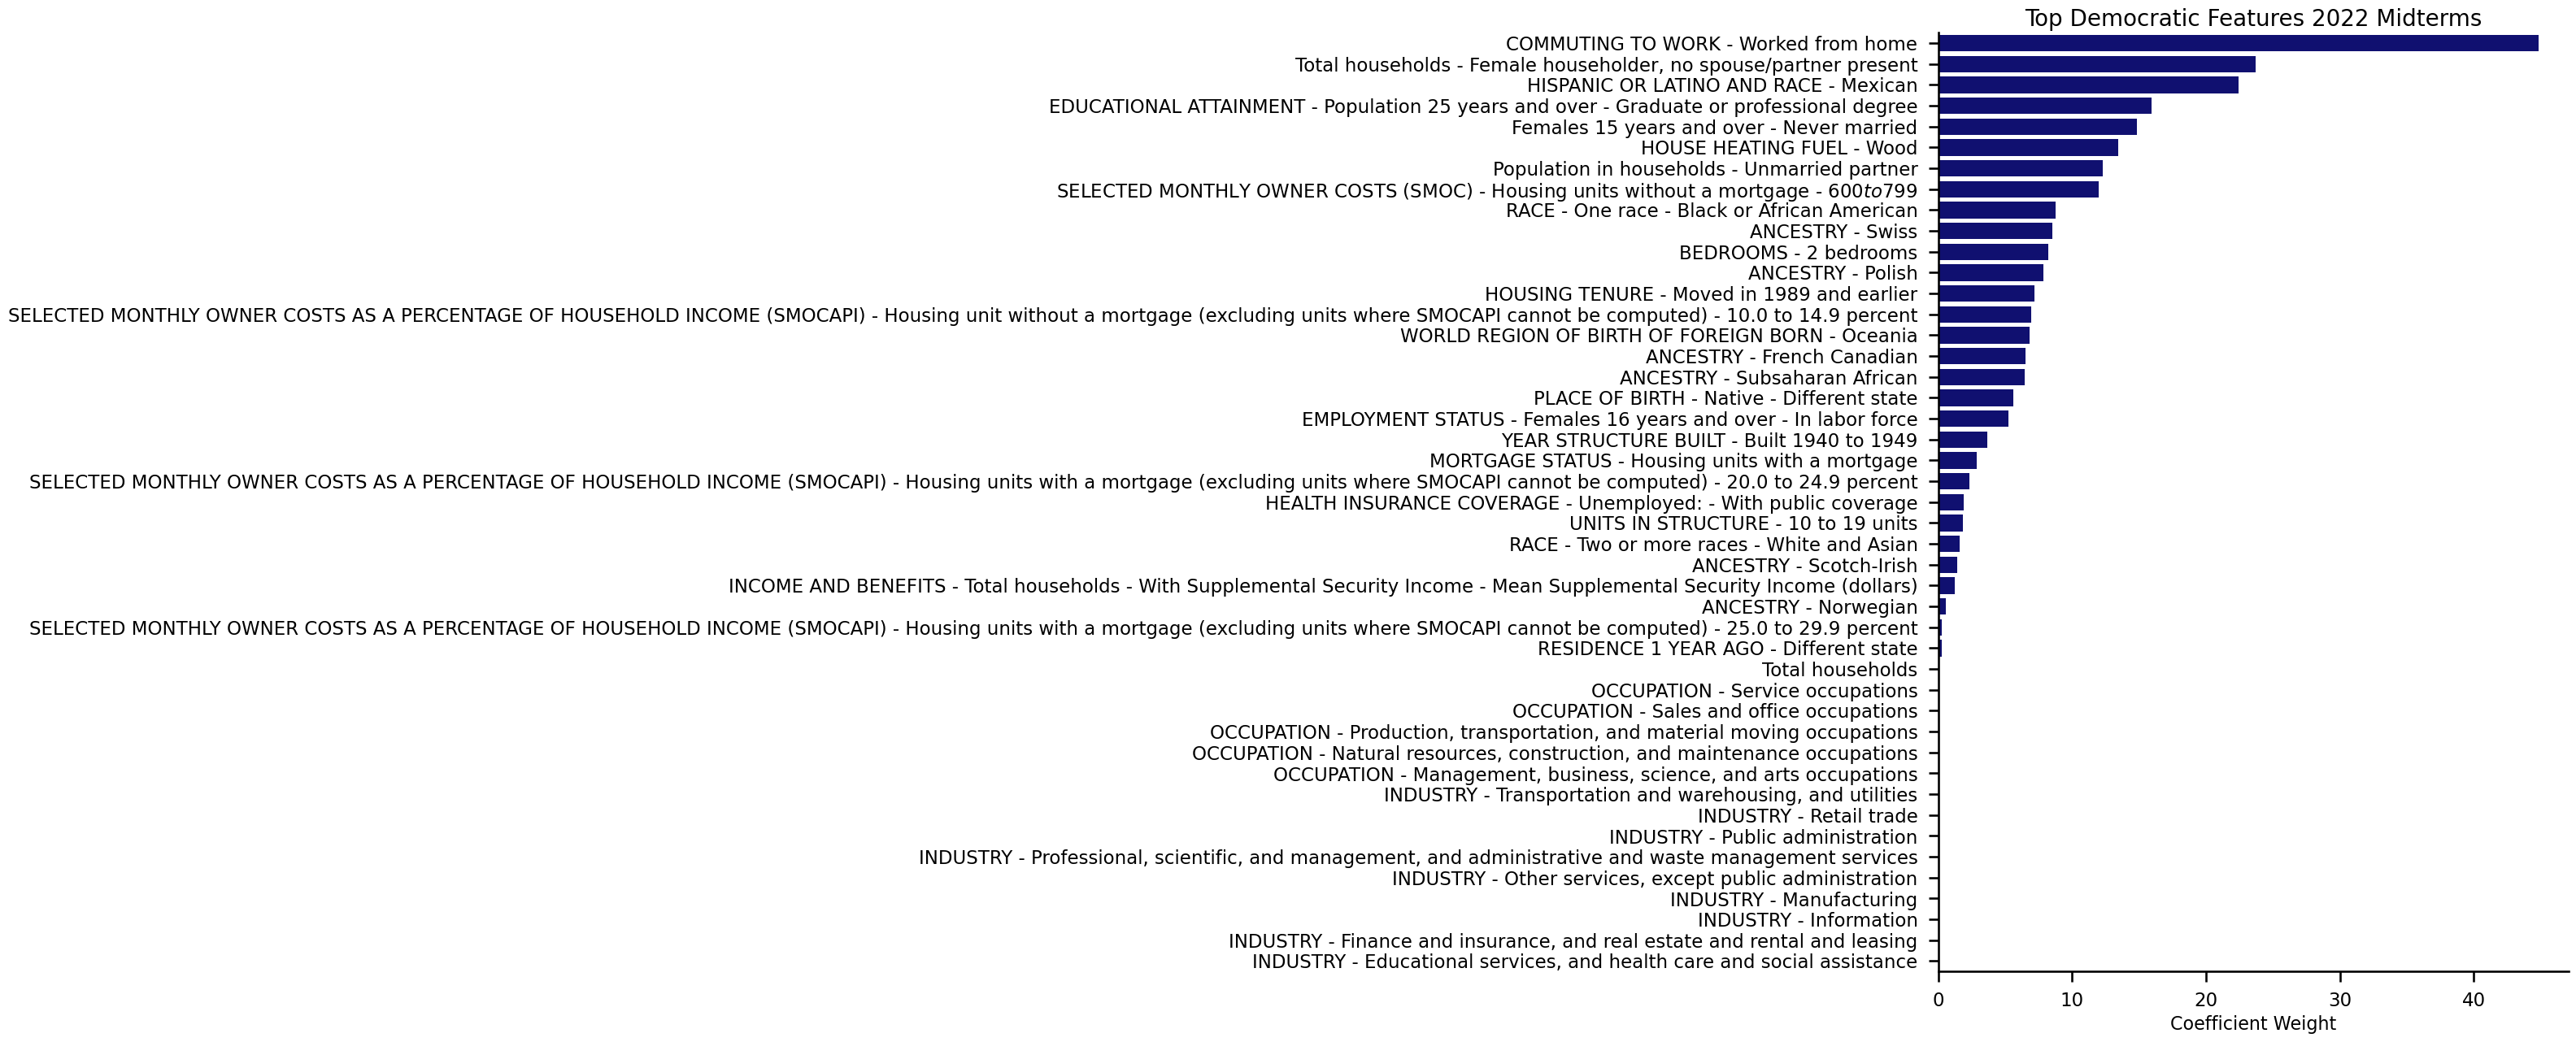

<Figure size 1040x715 with 0 Axes>

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract features and their weights into separate lists
democratic_features_22, democratic_weights_22 = zip(*top_democratic_features_22)

# Ensure the strongest predictor is at the top by reversing the order
democratic_features_22 = list(democratic_features_22)[::-1]
democratic_weights_22 = list(democratic_weights_22)[::-1]

# Set the context for the plot
sns.set_context("talk")

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 15))

# Plot the Democratic features with a solid blue color
sns.barplot(x=democratic_weights_22, y=democratic_features_22, color='navy', ax=ax)

# Set labels and title
ax.set_xlabel('Coefficient Weight', fontsize=16)
ax.set_title('Top Democratic Features 2022 Midterms', fontsize=20)  # Adjust title as needed

# Remove axes spines on the top and right
sns.despine()

# Show the plot
plt.show()

# Save the plot to a file
plt.savefig('top_democratic_features_2022_midterms.png', bbox_inches='tight', dpi=300)


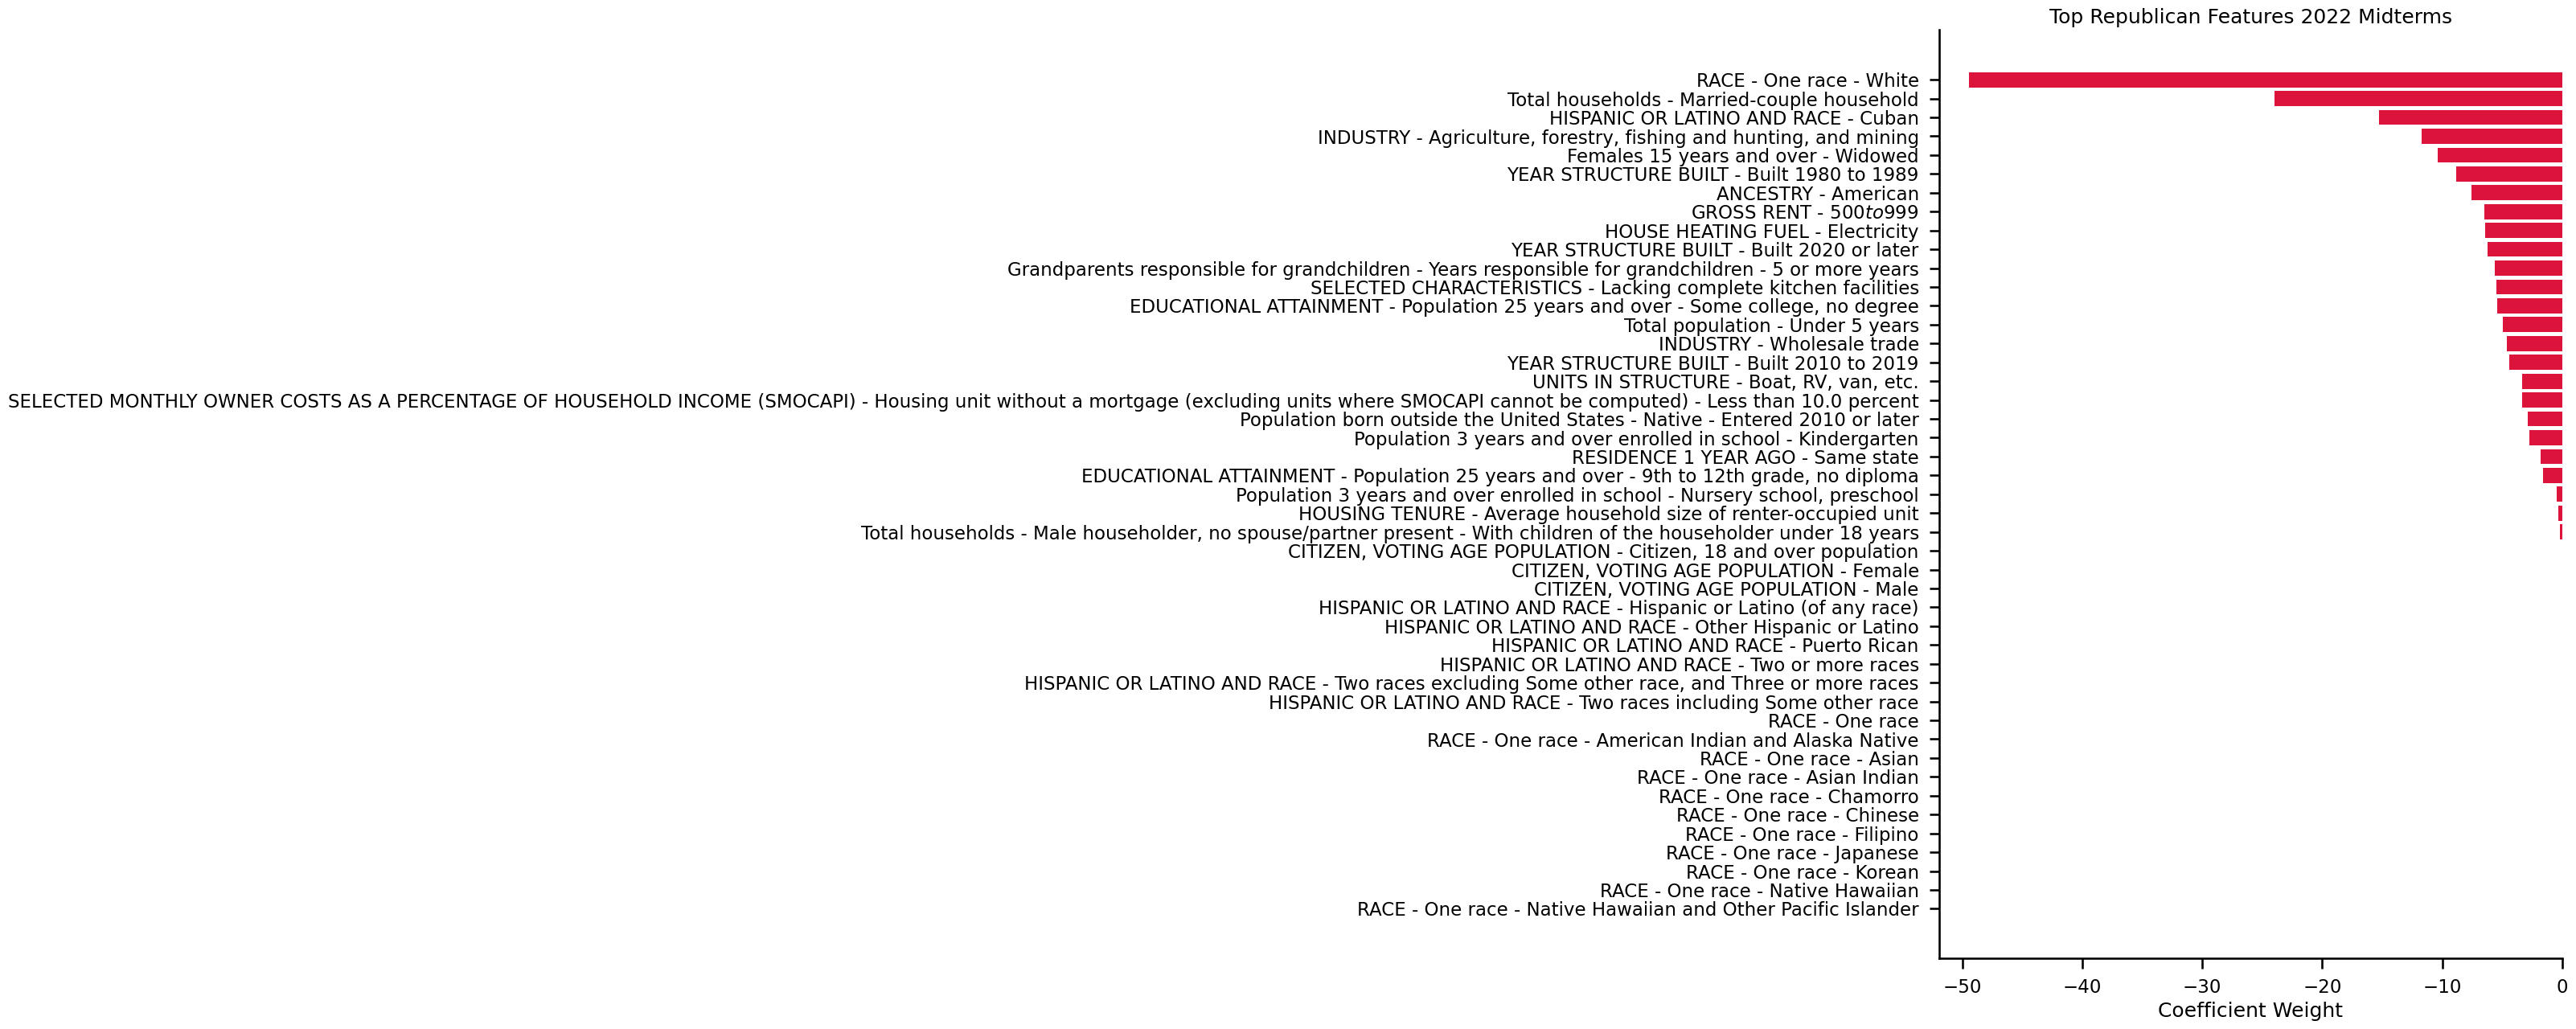

<Figure size 1040x715 with 0 Axes>

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort the features based on the absolute weights to ensure the strongest predictor is at the top
republican_features_22, republican_weights_22 = zip(*sorted(top_republican_features_22, key=lambda x: abs(x[1]), reverse=True))

# Set the context for the plot
sns.set_context("talk")  # Adjust to "poster" for even larger elements

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 15))

# Plot each bar with solid crimson color
for i, (feature, weight) in enumerate(zip(republican_features_22, republican_weights_22)):
    ax.barh(i, weight, color='crimson')

# Set the y-ticks to the feature names
ax.set_yticks(np.arange(len(republican_features_22)))
ax.set_yticklabels(republican_features_22)

# Invert the y-axis to have the strongest predictors at the top
ax.invert_yaxis()

# Set labels and title
ax.set_xlabel('Coefficient Weight')
ax.set_title('Top Republican Features 2022 Midterms')

# Remove spines on the top and right
sns.despine()

# Show the plot
plt.show()

# Save the visualization as a PNG file
plt.savefig('top_republican_features_2022_midterms.png', bbox_inches='tight', dpi=300)
